In [58]:
# required google colab installations
!pip install torchinfo torchmetrics wandb mlxtend==0.22

In [59]:
# import libraries
import random
import math
from pathlib import Path
import sys

from tqdm.auto import tqdm


import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

import torchinfo # show model summary

# helper functions 
#from helpers import display_images

# pytorch modules
import torch
from torch.utils.data import DataLoader

# torch vision modules
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn

# metrics module
import torchmetrics

# tracking metrics
import wandb

##### Hyper-parameter Initialisations

In [60]:
config = dict(
    epochs=1,
    learning_rate=1e-3,
    batch_size= 32,
    optimiser="SGD",
    dataset="MNIST",
    architecture="VGG-11",
)

In [61]:
run_name = f"{config['architecture']}_{config['optimiser']}_{config['learning_rate']}_{config['batch_size']}_{config['dataset']}"
print(run_name)

VGG-11_SGD_0.001_32_MNIST


In [62]:
# initialise wandb project
wandb.init(project="ECS795P_Classic", config=config, name=run_name)

In [63]:
config = wandb.config
print(f"Hyper-parameter configurations: \n{config}")

Hyper-parameter configurations: 
{'epochs': 1, 'learning_rate': 0.001, 'batch_size': 32, 'optimiser': 'SGD', 'dataset': 'MNIST', 'architecture': 'VGG-11'}


In [64]:
def display_images(image_dataloader: DataLoader, class_labels, n_rows: int =3, n_cols:int =5, figsize: tuple =(12,6)):

    """
    displays images from dataloader
    """
    # display MNIST sample images
    #n_rows, n_cols = 3, 5
    n_samples = n_rows * n_cols # number sample images to display

    data, label = next(iter(image_dataloader))
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    for i, image in enumerate(data[:n_samples]):
        image = image.detach()[0]
        #image = image.squeeze(dim=0)
        axs[i%n_rows, i//n_rows].imshow(image.numpy(), cmap="gray")
        axs[i%n_rows, i//n_rows].set(xticks=[], yticks=[])
        axs[i%n_rows, i//n_rows].set_title(class_labels[label[i]])
        
    return fig

In [65]:
def display_predicted_images(model, image_dataloader: DataLoader, class_labels, n_rows: int =3, n_cols:int =5, figsize: tuple =(12,6)):

    """
    displays images from dataloader
    """
    # display MNIST sample images
    n_samples = n_rows * n_cols # number sample images to display

    data, label = next(iter(image_dataloader))

    model = model.to("cpu")

    model.eval()
    with torch.inference_mode():
        model_predictions_logits = model(data)
        predictions = nn.functional.softmax(model_predictions_logits, dim=0).argmax(dim=1)

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    for i, image in enumerate(data[:n_samples]):
        image = image.detach()[0]
        #image = image.squeeze(dim=0)
        axs[i%n_rows, i//n_rows].imshow(image.numpy(), cmap="gray")
        axs[i%n_rows, i//n_rows].set(xticks=[], yticks=[])
        title = f"Actual Class {class_labels[label[i]]}\n Predicted Class: {class_labels[predictions[i]]}"
        axs[i%n_rows, i//n_rows].set_title(title)

    return fig

In [66]:
# device agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current hardware device: {DEVICE}")

Current hardware device: cpu


#### Downloading and Loading Datasets

In [67]:
# image Transforms
image_tranforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
    ])


In [68]:
# load MNIST datasets
# MNIST train data
train_data = datasets.MNIST(
    root="mnist_data",
    train=True,
    transform=image_tranforms,
    download=True,
)

# MNIST test data
test_data = datasets.MNIST(
    root="mnist_data",
    train=False,
    transform=image_tranforms,
    download=True,
)

In [69]:
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")
print(f"Image size: {np.array(train_data[0][0].shape)}")

Train data size: 60000
Test data size: 10000
Image size: [  3 224 224]


In [70]:
# train dataloader iterable
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=config.batch_size,
    shuffle=True
)

# test dataloader iterable
test_dataloader= DataLoader(
    dataset=test_data,
    batch_size=config.batch_size,
)

In [71]:
class_labels = train_data.classes # images class labels
print(f"class labels: {class_labels}")

class labels: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


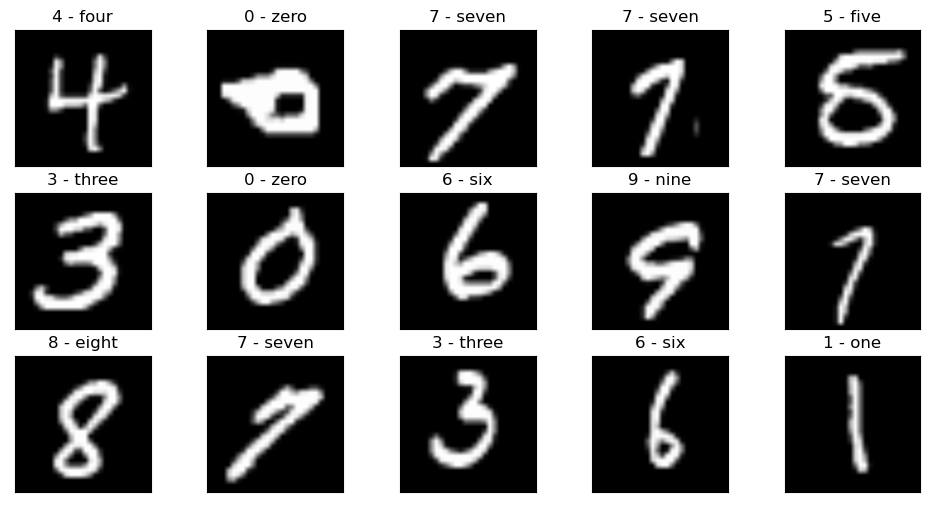

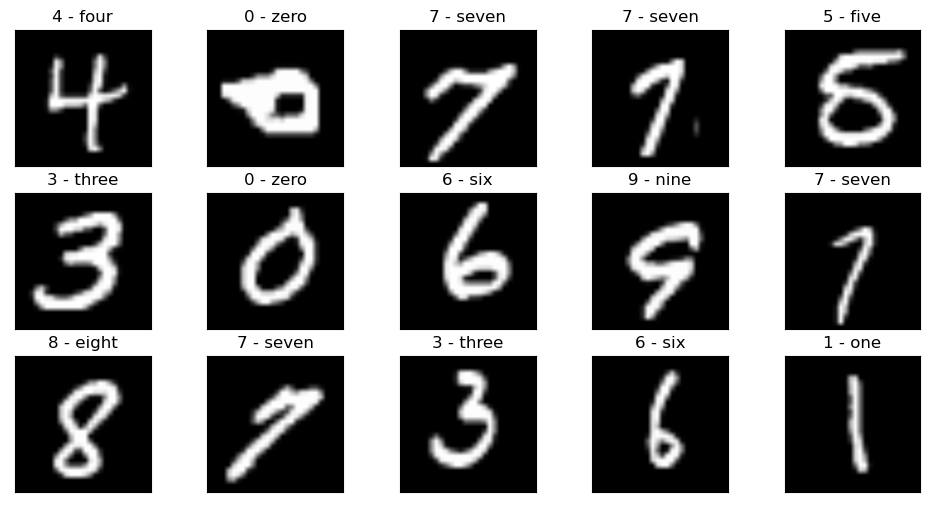

In [72]:
display_images(train_dataloader, class_labels=class_labels, n_cols=5, n_rows=3)

#### VGG Baseline Model

In [159]:
class VGGVanilla(nn.Module):
        # architecture configurations

    arc_config = {
    "A": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "B": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "D": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "E": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
    }

    def __init__(self, vgg_type: str = "A", output_classes: int = 1000, p_dropout: float = 0.5):
        super().__init__()
        self.conv_layers = self._make_layers(vgg_type) # stack of CNN layers
        
        # average pool
        self.avg_pool = nn.AdaptiveAvgPool2d((7,7))
        
        # Fully-Connected (FC) layers
        self.fc_layer = nn.Sequential(
             nn.Linear(512 * 7 * 7, 4096),
             nn.ReLU(),
             nn.Dropout(p=p_dropout),
             nn.Linear(4096, 4096),
             nn.ReLU(),
             nn.Dropout(p=p_dropout),
             nn.Linear(4096, output_classes)
        )
    
    def _make_layers(self, vgg_type: str):
     CNN_layers = []
     input_channel = 3
     config = self.arc_config[vgg_type]

     for l in config:
          if l == "M":
               CNN_layers.append(nn.MaxPool2d((2,2), stride=(2,2)))
          else:
               CNN_layers += [nn.Conv2d(input_channel, l, kernel_size=3, stride=1, padding=1), nn.ReLU()]
               input_channel = l
     return nn.Sequential(*CNN_layers)

    def forward(self, x):
     x = self.conv_layers(x)
     x = self.avg_pool(x)
     x = x.view(x.shape[0], -1)
     x = self.fc_layer(x)
     return x


In [160]:
vgg_model = VGGVanilla(vgg_type="A", output_classes=10)

In [161]:
vgg_model

VGGVanilla(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 5

In [162]:
# display model architecture
torchinfo.summary(vgg_model,
                  input_size=(32, 3, 224, 224), 
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=30,
                  row_settings=["var_names"]
                  )

Layer (type (var_name))                  Input Shape                    Output Shape                   Param #                        Trainable
VGGVanilla (VGGVanilla)                  [32, 3, 224, 224]              [32, 10]                       --                             True
├─Sequential (conv_layers)               [32, 3, 224, 224]              [32, 512, 7, 7]                --                             True
│    └─Conv2d (0)                        [32, 3, 224, 224]              [32, 64, 224, 224]             1,792                          True
│    └─ReLU (1)                          [32, 64, 224, 224]             [32, 64, 224, 224]             --                             --
│    └─MaxPool2d (2)                     [32, 64, 224, 224]             [32, 64, 112, 112]             --                             --
│    └─Conv2d (3)                        [32, 64, 112, 112]             [32, 128, 112, 112]            73,856                         True
│    └─ReLU (4)           

In [163]:
loss_fn = nn.CrossEntropyLoss()
if config.optimiser == "SGD":
    optimiser = torch.optim.SGD(vgg_model.parameters(), lr=config.learning_rate)
elif config.optimiser == "ADAM":
    optimiser = torch.optim.Adam(vgg_model.parameters(), lr=config.learning_rate)

In [164]:
# metrics definition
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)

In [165]:
# monitor parameter values i.e weights and biases and model gradients
wandb.watch(vgg_model, criterion=loss_fn, log="all")

[]

In [166]:
def train_model(model, dataloader: torch.utils.data.DataLoader):
    """
    
    """
    train_acc, train_loss = 0, 0
    model.train()
    for batch_data, batch_label in train_dataloader:
        batch_data = batch_data.to(DEVICE)
        batch_label = batch_label.to(DEVICE)\

        pred_logits = model(batch_data)

        train_batch_loss = loss_fn(pred_logits, batch_label)
        train_loss += train_batch_loss

        preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
        print(preds)
        print(preds.shape)
        train_batch_acc = accuracy_metric(preds.cpu(), batch_label.cpu()) * 100
        train_acc += train_batch_acc

        optimiser.zero_grad()

        train_batch_loss.backward()

        optimiser.step()
    
    # average of metrics per batch
    train_acc /= len(train_dataloader)
    train_loss /= len(train_dataloader)

    return train_loss, train_acc

In [167]:
def test_model(model, dataloader: torch.utils.data.DataLoader):
    """
    
    """
    test_loss, test_acc =  0, 0
    model.eval() # set model to evaluation mode
    with torch.inference_mode():
        for test_batch_data, test_batch_label in dataloader:

            test_batch_data = test_batch_data.to(DEVICE)
            test_batch_label = test_batch_label.to(DEVICE)

            pred_logits = model(test_batch_data)

            test_batch_loss = loss_fn(pred_logits, test_batch_label)
            test_loss += test_batch_loss

            preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
            
            batch_acc = accuracy_metric(preds.cpu(), test_batch_label.cpu()) * 100
            test_acc += batch_acc
        
        # average of loss metrics
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    return test_loss, test_acc

In [168]:
def model_prediction(model, dataloader: torch.utils.data.DataLoader):
    """
    
    """
    all_preds = []
    model.to(DEVICE)
    model.eval() # set model to evaluation mode
    with torch.inference_mode():
        for test_batch_data, test_batch_label in dataloader:

            test_batch_data = test_batch_data.to(DEVICE)
            test_batch_label = test_batch_label.to(DEVICE)

            pred_logits = model(test_batch_data)
            preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
            
            all_preds.append(preds.to("cpu"))
        
    all_preds_tensor = torch.cat(all_preds)
    return all_preds_tensor

##### Model Training

In [169]:

for epoch in tqdm(range(config.epochs)):

    # MODEL TRAINING
    train_loss, train_accuracy = train_model(vgg_model, train_dataloader)

    # MODEL EVALUATION
    test_loss, test_accuracy = test_model(vgg_model, test_dataloader)
    
    # print training metrics
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss: .3f}\t Training accuracy: {train_accuracy: .3f}", end="\t")
    print(f"Test loss: {test_loss: .3f}\t Test acc: {test_accuracy: .3f}")

    # log epoch metrics to WandB
    epoch_log_dict = {
        "training_accuracy": train_accuracy,
        "training_loss": train_loss,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }
    wandb.log(epoch_log_dict)



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([6, 3, 3, 0, 4, 9, 7, 0, 3, 2, 2, 1, 9, 5, 5, 8, 8, 8, 6, 7, 5, 2, 2, 3,
        2, 9, 5, 3, 1, 7, 0, 7])
torch.Size([32])
tensor([8, 0, 6, 5, 2, 2, 5, 8, 7, 9, 1, 4, 3, 9, 2, 5, 6, 3, 2, 7, 0, 0, 7, 4,
        8, 9, 6, 4, 7, 1, 7, 7])
torch.Size([32])
tensor([6, 3, 2, 0, 6, 8, 7, 9, 8, 0, 4, 1, 1, 0, 8, 8, 9, 4, 3, 0, 0, 0, 2, 9,
        6, 8, 7, 3, 0, 3, 8, 8])
torch.Size([32])
tensor([6, 4, 4, 9, 5, 2, 5, 7, 3, 5, 8, 7, 2, 7, 8, 2, 2, 0, 8, 5, 4, 1, 1, 6,
        4, 4, 3, 8, 4, 9, 8, 5])
torch.Size([32])
tensor([1, 9, 7, 2, 6, 7, 1, 4, 8, 0, 7, 0, 8, 9, 8, 6, 2, 6, 2, 5, 5, 6, 7, 5,
        6, 5, 1, 4, 3, 8, 4, 2])
torch.Size([32])
tensor([4, 8, 9, 3, 8, 4, 0, 1, 2, 8, 3, 2, 6, 5, 8, 1, 8, 2, 7, 2, 9, 0, 2, 2,
        1, 4, 0, 6, 3, 8, 6, 6])
torch.Size([32])


### Visualisations

#### Model accuracy and loss


In [ ]:
# show logged metrics
%wandb mustious/ECS795P_Classic

#### Sample Images of Predicted Classes

In [ ]:
predicted_images_fig = display_predicted_images(vgg_model, test_dataloader, class_labels=class_labels, figsize=(15,10))
plt.savefig(f"{config.architecture}_sample_model_prediction.jpg")
plt.show()

# log prediction image in wandb
wandb.log({"sample_predictions": predicted_images_fig})

### Confusion Matrix Visualisation


In [ ]:
predictions = model_prediction(vgg_model, test_dataloader)

confusion_matrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(class_labels))
confusion_matrix_tensor = confusion_matrix(predictions, test_data.targets)

confusion_matrix_fig, ax = plot_confusion_matrix(
    confusion_matrix_tensor.numpy(),
    class_names= class_labels,
    figsize=(10, 7))
plt.show()

# log prediction image in wandb
wandb.log({"confusion_matrix": confusion_matrix_fig})